In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


from tqdm import trange
from sklearn.manifold import TSNE
import zarr

from pathlib import Path

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [3]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"
# Load the data
sim1 = zarr.open(data_path / "one_leg_low_sim.zarr", mode="r")
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim1_imgs = sim1["color_image2"]
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]

print(f"Loaded {len(sim1['episode_ends'])} trajectories containing {sim1_imgs.shape[0]} frames")
print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 23371 frames
Loaded 25 trajectories containing 12263 frames
Loaded 50 trajectories containing 27699 frames


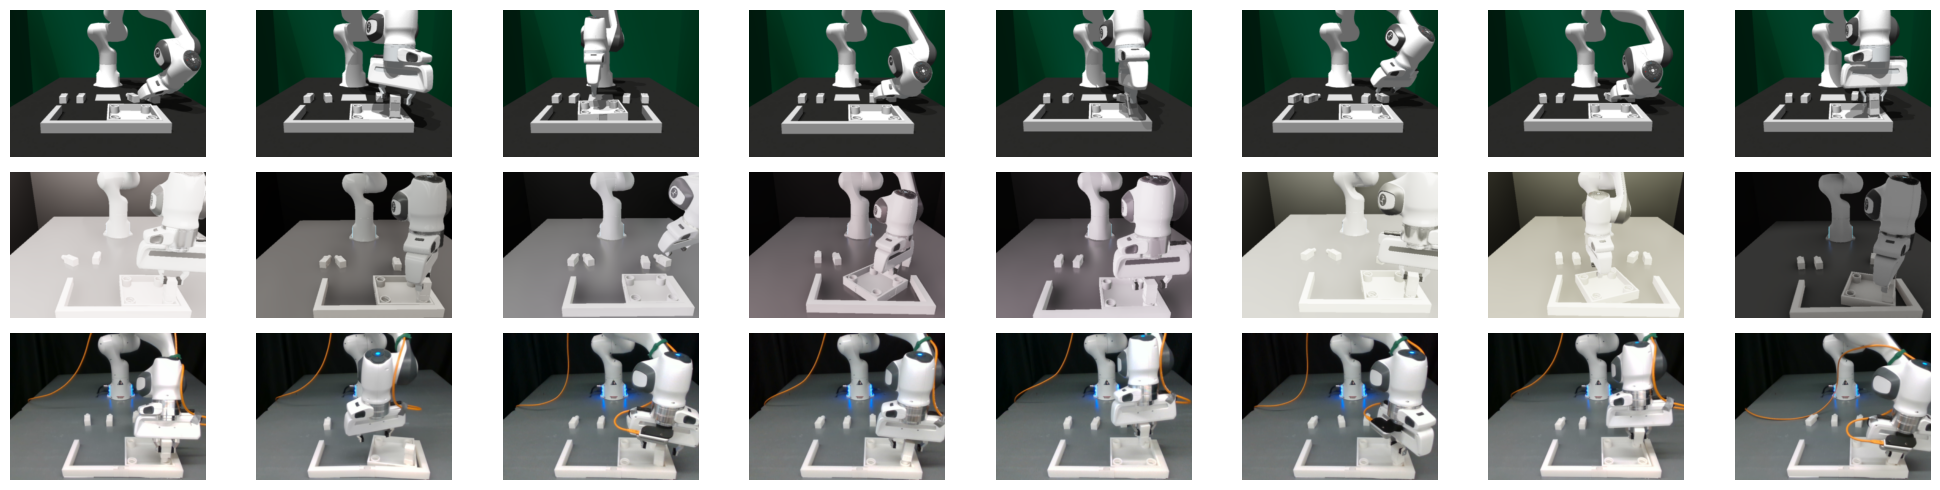

In [4]:
# Sample 8 images from each dataset
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=8, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(3, 8, figsize=(20, 5))

# Display the sampled images
for i, idx in enumerate(sim1_indices):
    axes[0, i].imshow(sim1_imgs[idx])
    axes[0, i].axis("off")

for i, idx in enumerate(sim2_indices):
    axes[1, i].imshow(sim2_imgs[idx])
    axes[1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2, i].imshow(real_imgs[idx])
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

In [5]:
class DinoV2Encoder(torch.nn.Module):
    def __init__(self, model_name="dinov2_vits14", freeze=True, device="cuda"):
        super().__init__()
        assert model_name in [
            "dinov2_vits14",
            "dinov2_vitb14",
            "dinov2_vitl14",
            "dinov2_vitg14",
        ]
        self.device = device

        # Model wants a batch of images of shape (batch_size, 3, 224, 224) and normalized
        self.model = torch.hub.load("facebookresearch/dinov2", model_name)

        self.encoding_dim = self.model.norm.normalized_shape[0]

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

            self.model.eval()

        self.model = self.model.to(device)

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    # Expect input to be a batch of images of shape (batch_size, 3, 224, 224) in range [0, 255]
    def forward(self, x):
        # Normalize images
        x = x / 255.0
        x = self.normalize(x)
        x = self.model(x)
        return x

In [6]:
dinov2 = DinoV2Encoder(model_name="dinov2_vitb14", freeze=True, device=device)

# Assuming the encoder expects images of size (3, 224, 224) [0, 255]
random_input = torch.randint(0, 255, size=(1, 3, 224, 224), device=device, dtype=torch.float32)

# Pass the random data through the encoder
with torch.no_grad():
    output = dinov2(random_input)


output.shape

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


torch.Size([1, 768])

In [21]:
resize = transforms.Resize((224, 224))

100%|██████████| 5/5 [01:00<00:00, 12.02s/it]


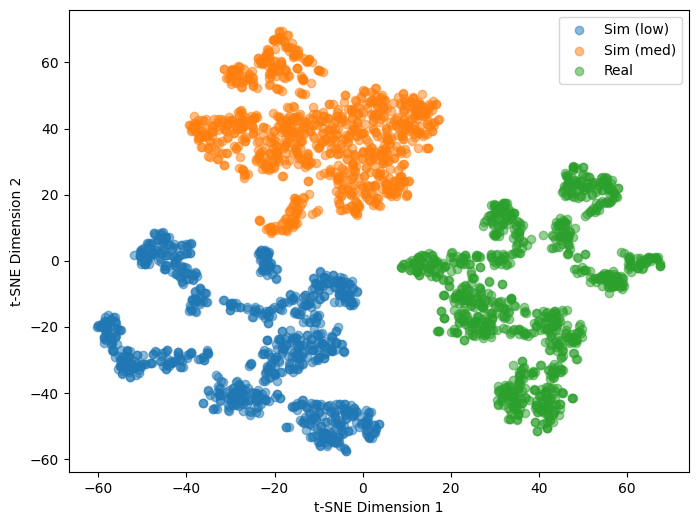

In [22]:
num_samples = 1000
batch_size = 200

# Sample indices for each dataset
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=num_samples, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=num_samples, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=num_samples, replace=False)

# Create tensors to store the embeddings
sim1_embeddings = torch.zeros(num_samples, output.shape[1])
sim2_embeddings = torch.zeros(num_samples, output.shape[1])
real_embeddings = torch.zeros(num_samples, output.shape[1])

# Compute embeddings for the sampled images in batches
with torch.no_grad():
    for i in trange(0, num_samples, batch_size):
        # Process sim1 images in batches
        batch_indices = sim1_indices[i : i + batch_size]
        sim_batch = (
            resize(torch.from_numpy(sim1_imgs[batch_indices]).permute(0, 3, 1, 2)).float().cuda()
        )
        sim1_embeddings[i : i + batch_size] = dinov2(sim_batch).cpu()

        # Process sim2 images in batches
        batch_indices = sim2_indices[i : i + batch_size]
        sim_batch = (
            resize(torch.from_numpy(sim2_imgs[batch_indices]).permute(0, 3, 1, 2)).float().cuda()
        )
        sim2_embeddings[i : i + batch_size] = dinov2(sim_batch).cpu()

        # Process real images in batches
        batch_indices = real_indices[i : i + batch_size]
        real_batch = (
            resize(torch.from_numpy(real_imgs[batch_indices]).permute(0, 3, 1, 2)).float().cuda()
        )
        real_embeddings[i : i + batch_size] = dinov2(real_batch).cpu()

# Embeddings are now stored in sim_embeddings and real_embeddings tensors
# Concatenate the embeddings and create labels
all_embeddings = torch.cat([sim1_embeddings, sim2_embeddings, real_embeddings]).cpu().numpy()
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples), np.ones(num_samples) * 2])

# Fit t-SNE on the embeddings
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(
    embeddings_2d[:num_samples, 0], embeddings_2d[:num_samples, 1], label="Sim (low)", alpha=0.5
)
plt.scatter(
    embeddings_2d[num_samples : 2 * num_samples, 0],
    embeddings_2d[num_samples : 2 * num_samples, 1],
    label="Sim (med)",
    alpha=0.5,
)
plt.scatter(
    embeddings_2d[2 * num_samples :, 0],
    embeddings_2d[2 * num_samples :, 1],
    label="Real",
    alpha=0.5,
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

torch.Size([200, 240, 320, 3])